# Factorization Machines

In [ ]:
import os
import json
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Feature Engineering

- Perform NLP to clean the categorical data and combine to create a Bag-of-words vector
- Augment data with User Demographics from MovieLens Dataset
- Create the vector table

In [ ]:
# convert list into pandas dataframe
meta = pd.read_json('/content/drive/MyDrive/Machine Learning- Group Project/meta_Magazine_Subscriptions.json', lines=True)
print(len(meta))

3385


In [ ]:
meta_df = meta[['asin','category']]
print(len(meta_df)),
meta_df.head(3)

3385


,asin,category
0,B00005N7NQ,"[Magazine Subscriptions, Professional & Educat..."
1,B00005N7OC,"[Magazine Subscriptions, Arts, Music &amp; Pho..."
2,B00005N7OD,"[Magazine Subscriptions, Fashion &amp; Style, ..."


In [ ]:
#drop duplicate meta data
print(meta.duplicated(subset=['asin']).sum())
meta_df.drop_duplicates(subset=['asin'],inplace=True)

1065


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
#drop rows with no category entry
#dataype of col is list and boolean(list_item) gives True if it contains items and false if none
meta_df = meta_df[meta_df["category"].astype(bool)]

In [ ]:
#remove the first item in category list which is same for all
meta_df['categ2'] = meta_df['category'].apply(lambda x: x[1:])
del meta_df['category']
del meta_df['categ2']

In [ ]:
#clean up categories to format needed for bag of words format
import re
import string

def clean_categ(categ_list):
  new_list = []
  for category in categ_list:
    # text = category.lower()
    text = re.sub(' & ', '', category)  #" & "
    text = re.sub(' &amp; ', '', text) #" &amp; "
    text = re.sub(' ', '', text) #removes space " "
    text = re.sub(',', '', text) #removes comma
    new_list.append(text)

  return new_list

In [ ]:
meta_df['clean_categ'] = meta_df['categ2'].apply(lambda x: clean_categ(x))

In [ ]:
meta_df.head(3)

,asin,clean_categ
0,B00005N7NQ,"[ProfessionalEducationalJournals, Professional..."
1,B00005N7OC,"[ArtsMusicPhotography, Music]"
2,B00005N7OD,"[FashionStyle, Women]"


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Machine Learning- Group Project/Magazine_Subscriptions.csv', names=['asin','reviewerID','rating','timestamp'])
del df1['timestamp']
df1.head(3)

,asin,reviewerID,rating
0,B00005N7P0,AH2IFH762VY5U,5.0
1,B00005N7P0,AOSFI0JEYU4XM,5.0
2,B00005N7OJ,A3JPFWKS83R49V,3.0


In [ ]:
df1['reviewerID'].nunique(),df1['asin'].nunique()

(72098, 2428)

In [ ]:
user_df = df1[['reviewerID']].groupby('reviewerID') \
                          .size()  \
                          .reset_index(name='rvr_count')  \
                          .sort_values(['rvr_count'], ascending=False)
# user_less_rating_list = user_df[user_df['count'] <= 1]['reviewerID'].values
# print(len(user_less_rating_list))
# user_less_rating_list

In [ ]:
user_df.shape

(72098, 2)

In [ ]:
(user_df['rvr_count'] > 2).sum()

3092

In [ ]:
fm_df = df1.merge(user_df, on='reviewerID', how='left')
fm_df = fm_df[fm_df['rvr_count'] > 2]
fm_df.shape

(12689, 4)

In [ ]:
fm_df['reviewerID'].nunique(),fm_df['asin'].nunique()

(3092, 1305)

In [ ]:
item_df = fm_df[['asin']].groupby('asin') \
                          .size()  \
                          .reset_index(name='item_count')  \
                          .sort_values(['item_count'], ascending=False)
item_df

,asin,item_count
59,B00005N7SC,223
1258,B01CF3ECNK,201
659,B000FTJ7JQ,200
771,B000XXDJ70,200
767,B000WM6NZW,196
...,...,...
785,B001B65MI2,1
786,B001BKE2MU,1
789,B001E547FE,1
193,B000063XJN,1


In [ ]:
(item_df['item_count'] > 2).sum()

619

In [ ]:
fm_df2 = fm_df.merge(item_df, on='asin', how='left')
fm_df2 = fm_df2[fm_df2['item_count'] > 2]
fm_df2.shape

(11779, 5)

In [ ]:
fm_df3 = fm_df2[['rating','asin','reviewerID']].merge(meta_df, on='asin', how='inner')
fm_df3.shape

(10668, 4)

In [ ]:
fm_df3.head(3)

,rating,asin,reviewerID,clean_categ
0,3.0,B00005N7OJ,A3JPFWKS83R49V,"[HomeGarden, AntiquesCollectibles]"
1,5.0,B00005N7OJ,A2T0GO5G3JJ66V,"[HomeGarden, AntiquesCollectibles]"
2,3.0,B00005N7OJ,A1CEG4HICKGHUW,"[HomeGarden, AntiquesCollectibles]"


In [ ]:
fm_df3['reviewerID'].nunique(),fm_df3['asin'].nunique()

(3047, 522)

In [ ]:
#to one hot encode and make the list into new columns

# for i in fm_df3['category'].explode().unique():
#     fm_df3[i] = [1 if i in x else 0 for x in fm_df3['category']]
# fm_df3.shape

In [ ]:
#list of user ids for later indexing
print(fm_df3['reviewerID'].nunique())
user_list = fm_df3['reviewerID'].unique()
fm_df3['reviewerID'].unique(), len(fm_df3['reviewerID'].unique())

3047


(array(['A3JPFWKS83R49V', 'A2T0GO5G3JJ66V', 'A1CEG4HICKGHUW', ...,
        'AWDXPPUBSD5L3', 'A9WKW3THZGGEK', 'A3H9A8BW71RS61'], dtype=object),
 3047)

## User data from MovieLens dataset

In [ ]:
# data = np.loadtxt()
user_demo_data = pd.read_csv('/content/drive/MyDrive/Machine Learning- Group Project/data/users.dat', sep='::', header=None, engine='python', names=['userId','Gender','Age','Occupation','Zip-code'])
# user_demo_data['Gender'] = user_demo_data.Gender.map({'F':0, 'M':1})
user_demo_data = user_demo_data[user_demo_data['Age'] > 20]
# user_demo_data['Age'][user_demo_data.Age == 1] = 21
del user_demo_data['Zip-code']
del user_demo_data['userId']
del user_demo_data['Occupation']

print(user_demo_data.shape)
user_demo_data

(4715, 3)


,Gender,Age,Occupation
1,M,56,16
2,M,25,15
3,M,45,7
4,M,25,20
5,F,50,9
...,...,...,...
6035,F,25,15
6036,F,45,1
6037,F,56,1
6038,F,45,0


In [ ]:
# Bin the data to reduce the dimensions of the final vector

user_demo_data['age_group'] = pd.cut(x=user_demo_data['Age'],bins=[0, 30, 50, 80], labels=['young_age', 'middle_age', 'elder_age']) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1db2f7dd90>,
      dtype=object)

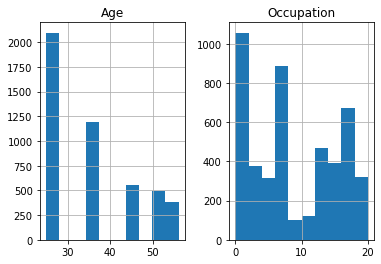

In [ ]:
user_demo_data.hist()

In [ ]:
user_demo_data['age_group'].value_counts()

middle_age    2239
young_age     2096
elder_age      380
Name: age_group, dtype: int64

In [ ]:
del user_demo_data['Age']
user_demo_data.head(3)

,Gender,age_group
1,M,elder_age
2,M,young_age
3,M,middle_age


In [ ]:
#sample user data from larger dataset to desired number of users

from sklearn.utils import resample

user_data2 = resample(user_demo_data, n_samples = 3047, random_state = 42)
user_data2.set_index(user_list, inplace=True)
user_data2.reset_index(inplace=True)
user_data2.rename(columns={'index':'reviewerID'}, inplace=True)
print(user_data2.shape)
user_data2.head(3)

(3047, 3)


,reviewerID,Gender,age_group
0,A3JPFWKS83R49V,M,young_age
1,A2T0GO5G3JJ66V,M,middle_age
2,A1CEG4HICKGHUW,F,young_age


In [ ]:
user_data2['age_group'].value_counts(),user_data2['Gender'].value_counts()

(middle_age    1403
 young_age     1392
 elder_age      252
 Name: age_group, dtype: int64, M    2200
 F     847
 Name: Gender, dtype: int64)

In [ ]:
fm_df4 = fm_df3.merge(user_data2, on='reviewerID', how='left')
fm_df4['rating'] = fm_df4['rating'].astype(int)
print(fm_df4.shape)
fm_df4.head(3)

(10668, 6)


,rating,asin,reviewerID,clean_categ,Gender,age_group
0,3,B00005N7OJ,A3JPFWKS83R49V,"[HomeGarden, AntiquesCollectibles]",M,young_age
1,5,B00005N7OJ,A2T0GO5G3JJ66V,"[HomeGarden, AntiquesCollectibles]",M,middle_age
2,3,B00005N7OJ,A1CEG4HICKGHUW,"[HomeGarden, AntiquesCollectibles]",F,young_age


# One Hot encoding variables

In [ ]:
for i in fm_df4['clean_categ'].explode().unique():
    fm_df4[i] = [1 if i in x else 0 for x in fm_df4['clean_categ']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
for i in fm_df4['age_group'].unique():
    fm_df4[i] = [1 if i in x else 0 for x in fm_df4['age_group']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
for i in fm_df4['Gender'].unique():
    fm_df4[i] = [1 if i in x else 0 for x in fm_df4['Gender']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
for i in fm_df4['reviewerID'].unique():
    fm_df4[i] = [1 if i in x else 0 for x in fm_df4['reviewerID']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
for i in fm_df4['asin'].unique():
    fm_df4[i] = [1 if i in x else 0 for x in fm_df4['asin']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
del fm_df4['asin']
del fm_df4['reviewerID']
del fm_df4['clean_categ']
del fm_df4['Gender']
del fm_df4['age_group']

In [ ]:
print(fm_df4.shape)
fm_df4.head(3)

(10668, 3703)


,rating,HomeGarden,AntiquesCollectibles,Technology,ComputersInternet,How-toHomeImprovements,FashionStyle,Women,Men,ArtsMusicPhotography,...,B00XII1TYC,B00YQH9874,B010EJ6MVM,B01177K4NM,B01177K4YG,B0123ULDTQ,B014RD16DA,B014RD17WA,B015HSVUG2,B019ZV1FJO
0,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# FM Model Building

In [ ]:
from sklearn.model_selection import train_test_split
import scipy

X = fm_df4.drop('rating', axis='columns').values
X = scipy.sparse.csr.csr_matrix(X, shape=(X.shape))
y = fm_df4['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
type(X_train),type(X_test),type(y_train),type(y_test)

(scipy.sparse.csr.csr_matrix,
 scipy.sparse.csr.csr_matrix,
 numpy.ndarray,
 numpy.ndarray)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((7467, 3702), (3201, 3702), (7467,), (3201,))

In [ ]:
!pip install git+https://github.com/coreylynch/pyFM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/coreylynch/pyFM to /tmp/pip-req-build-kewho9ti
  Running command git clone -q https://github.com/coreylynch/pyFM /tmp/pip-req-build-kewho9ti
  Created wheel for pyfm: filename=pyfm-0.0.0-cp37-cp37m-linux_x86_64.whl size=218593 sha256=890e67cab19e2facb3bd7260164ea20b5761cacac8e35a5728d70d813ab946f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6vts_dfr/wheels/0a/f8/8c/9ff76e4e3a3dd4ace45daa68d3aa298084e4771cb32c52bbe3
Successfully built pyfm
  Attempting uninstall: pyfm
    Found existing installation: pyfm 0.2.4
    Uninstalling pyfm-0.2.4:
      Successfully uninstalled pyfm-0.2.4


In [ ]:
from pyfm import pylibfm
# fm = pylibfm.FM()
fm = pylibfm.FM(num_factors=10, num_iter=100, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")

In [ ]:
fm.fit(X=X_train.astype(np.float),y=y_train.astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.81050
-- Epoch 2
Training MSE: 0.64485
-- Epoch 3
Training MSE: 0.62546
-- Epoch 4
Training MSE: 0.61205
-- Epoch 5
Training MSE: 0.59797
-- Epoch 6
Training MSE: 0.58370
-- Epoch 7
Training MSE: 0.56768
-- Epoch 8
Training MSE: 0.55226
-- Epoch 9
Training MSE: 0.53467
-- Epoch 10
Training MSE: 0.51440
-- Epoch 11
Training MSE: 0.49530
-- Epoch 12
Training MSE: 0.47318
-- Epoch 13
Training MSE: 0.45052
-- Epoch 14
Training MSE: 0.42836
-- Epoch 15
Training MSE: 0.40776
-- Epoch 16
Training MSE: 0.38692
-- Epoch 17
Training MSE: 0.36686
-- Epoch 18
Training MSE: 0.34872
-- Epoch 19
Training MSE: 0.33330
-- Epoch 20
Training MSE: 0.31667
-- Epoch 21
Training MSE: 0.30370
-- Epoch 22
Training MSE: 0.29173
-- Epoch 23
Training MSE: 0.28171
-- Epoch 24
Training MSE: 0.27006
-- Epoch 25
Training MSE: 0.26316
-- Epoch 26
Training MSE: 0.25476
-- Epoch 27
Training MSE: 0.24822
-- Epoch 28
Tra

In [ ]:
preds = fm.predict(X_test.astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [ ]:
list_of_tuples = list(zip(y_test,preds))
df = pd.DataFrame(list_of_tuples, columns = ['Actual', 'Prediction'])
df['delta'] = df['Actual'] - df['Prediction']

In [ ]:
df

,Actual,Prediction,delta
0,3,2.601987,0.398013
1,2,3.914806,-1.914806
2,5,4.912905,0.087095
3,5,4.660848,0.339152
4,5,4.959595,0.040405
...,...,...,...
3196,5,4.717459,0.282541
3197,1,2.369585,-1.369585
3198,5,4.370287,0.629713
3199,4,5.000000,-1.000000


In [ ]:
from sklearn.metrics import mean_squared_error
print("FM MSE: %.4f" % mean_squared_error(y_test,preds))

FM MSE: 1.0135


In [ ]:
mean_squared_error(y_test, preds, squared=False)

1.0067247650658846

# Appendix

## LightFM
- https://github.com/kapadias/mediumposts/blob/master/recommender/published_notebooks/recommendation_python_lightfm.ipynb
- https://towardsdatascience.com/recommendation-system-in-python-lightfm-61c85010ce17


## Neural Net
- https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/machine_learning/example_recommendation.ipynb
 - https://towardsdatascience.com/modern-recommendation-systems-with-neural-networks-3cc06a6ded2c

Resources: 
- https://github.com/coreylynch/pyFM
- https://rankfm.readthedocs.io/en/latest/quickstart.html
- https://www.analyticsvidhya.com/blog/2018/01/factorization-machines/
- https://www.kaggle.com/code/residentmario/notes-on-matrix-factorization-machines/notebook
- https://stackoverflow.com/questions/37202501/how-to-use-scikit-learn-dictvectorizer-to-get-encoded-dataframe-from-dense-dataf
- https://towardsdatascience.com/solving-business-usecases-by-recommender-system-using-lightfm-4ba7b3ac8e62
- https://github.com/aayushmnit/cookbook/blob/master/recsys.py